In [2]:
!make docker-image > /dev/null 2>&1

In [3]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [4]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

In [5]:
import polars as pl
from pathlib import Path
from plotnine import ggplot, aes, geom_line, geom_point, labs

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    combined_df = start_df.join(end_df, "pid")
    return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) ->(int, int, int):
    trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
    df = trace_df.filter(pl.col("full_name") == proc_name)
    df = df[index]
    pid = df["pid"][0]
    start_ns = df["start_ns"][0]
    end_ns = df["end_ns"][0]
    return pid, start_ns, end_ns

def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
    df = df.filter(pl.col("tgid") == pid)

    # Extract anon pages only
    df = df.with_columns(
        pl.when(pl.col("member") == "MM_ANONPAGES")
        .then(pl.col("count"))
        .otherwise(None)
        .fill_null(strategy="forward")
        .fill_null(strategy="backward")
        .alias("anon")
    )

    df = df.drop(["member", "count"])

    # Add a zero row to avoid missing early timestamps
    zero_df = pl.DataFrame({"tgid": pid, "ts_ns": -1, "anon": 0})
    df = pl.concat([df, zero_df]).sort("ts_ns")
    df = df.fill_null(strategy="forward")
    df = df.filter(pl.col("ts_ns") >= 0)

    # Final count is just anon
    df = df.with_columns(pl.col("anon").alias("count"))
    df = df.drop(["anon"])

    return df

    
def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
    new_frame_dict = {}
    for column_name in rss_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_ns"] = [start, end]
    df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
    return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

def get_proper_rss(proc_path: Path, rss_path: Path, rss_name: str, rss_ind: int, runner_name: str, runner_ind: int, tag: str):
    proc_trace_df = pl.read_parquet(proc_path)
    rss_df = pl.read_parquet(rss_path)

    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, rss_name, rss_ind)
    clean_rss_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
    return clean_rss_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns")).with_columns(pl.lit(tag).alias('policy'))

def create_rss_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        append_df = get_proper_rss(filedict["process_trace"],
                                   filedict["mm_rss_stat"],
                                   proc_tag, proc_ind,
                                   time_proc_tag,
                                   time_proc_index,
                                   tag).drop(["tgid", "ts_ns"])
        df = pl.concat([df, append_df])
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    plt0 = (ggplot(df)
            + aes("norm_ts_mins", y="count", colour="policy")
            + geom_point()
            + geom_line()
            + labs(x="Time (mins)",
                   y="4kB Pages",
                   title=title)
           )
    return plt0

def filter_dtlb_with_ts(dtlb_trace_df: pl.DataFrame, start: int, end: int):
    start_us = start // 1000  # Convert ns to us
    end_us = end // 1000      # Convert ns to us
    
    print(f"Filtering DTLB data from {start_us} to {end_us} μs")
    print(f"DTLB data time range: {dtlb_trace_df['ts_uptime_us'].min()} to {dtlb_trace_df['ts_uptime_us'].max()} μs")
    print(f"DTLB data shape before filtering: {dtlb_trace_df.shape}")
    
    new_frame_dict = {}
    for column_name in dtlb_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_uptime_us"] = [start_us, end_us]
    
    df = dtlb_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_uptime_us")).fill_null(strategy="forward").fill_null(strategy="backward")
    
    filtered_df = df.filter(pl.col("ts_uptime_us").is_between(start_us, end_us, closed='both'))
    print(f"DTLB data shape after filtering: {filtered_df.shape}")
    
    if filtered_df.shape[0] > 0:
        print("Sample of filtered data (first 3 rows):")
        print(filtered_df.head(3))
        print("Sample of filtered data (last 3 rows):")
        print(filtered_df.tail(3))
    
    return filtered_df

def clean_dtlb_pid(dtlb_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    # Drop unnecessary columns, but keep the ones we need
    df = dtlb_df.drop(["pid", "pmu_enabled_time_us", 
                     "pmu_running_time_us", "collection_id"])
    
    # Filter to only include rows for the specified process
    df = df.filter(pl.col("tgid") == pid)
    
    # Keep all CPUs, sort by timestamp and CPU
    df = df.sort(["ts_uptime_us", "cpu"])
    
    print(f"DTLB data for pid {pid}: {df.shape[0]} rows")
    
    return df

def get_proper_dtlb(proc_path: Path, dtlb_path: Path, dtlb_name: str, dtlb_ind: int, 
                   runner_name: str, runner_ind: int, tag: str):
    proc_trace_df = pl.read_parquet(proc_path)
    dtlb_df = pl.read_parquet(dtlb_path)
    
    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, dtlb_name, dtlb_ind)
    
    # Basic processing - keep all CPUs
    clean_df = clean_dtlb_pid(dtlb_df, pid)
    filtered_df = filter_dtlb_with_ts(clean_df, start, end)
    
    if filtered_df.shape[0] == 0:
        # Return empty DataFrame with correct schema
        return pl.DataFrame({
            "ts_uptime_us": [],
            "cumulative_dtlb_misses": [],
            "tgid": [],
            "norm_ts_ns": [],
            "policy": []
        })
    
    # Get unique timestamps
    unique_ts = filtered_df.select("ts_uptime_us").unique().sort("ts_uptime_us")
    
    # Get unique CPUs
    unique_cpus = filtered_df.select("cpu").unique().sort("cpu")
    
    # For each CPU, fill missing timestamps with last observed value or 0
    cpu_dfs = []
    for cpu in unique_cpus["cpu"]:
        cpu_df = filtered_df.filter(pl.col("cpu") == cpu).select(["ts_uptime_us", "cumulative_dtlb_misses"])
        
        # Create a DataFrame with all unique timestamps for this CPU
        full_ts_df = unique_ts.join(cpu_df, on="ts_uptime_us", how="left")
        
        # Fill nulls with last observed value or 0 and ensure monotonic increase
        full_ts_df = full_ts_df.with_columns(
            pl.col("cumulative_dtlb_misses")
            .fill_null(strategy="forward")
            .fill_null(0)
            .cum_max()
            .alias("cumulative_dtlb_misses")
        ).with_columns(
            pl.lit(cpu).alias("cpu")
        )
        
        cpu_dfs.append(full_ts_df)
    
    # Combine all CPU DataFrames
    combined_df = pl.concat(cpu_dfs)
    
    # Sum DTLB misses across CPUs for each timestamp
    aggregated_df = combined_df.group_by("ts_uptime_us").agg(
        cumulative_dtlb_misses=pl.col("cumulative_dtlb_misses").sum()
    ).sort("ts_uptime_us")
    
    # Ensure strictly increasing misses
    aggregated_df = aggregated_df.with_columns(
        pl.col("cumulative_dtlb_misses").cum_max().alias("cumulative_dtlb_misses")
    )
    
    # Add normalized timestamps and policy
    min_ts = aggregated_df["ts_uptime_us"].min()
    result_df = aggregated_df.with_columns(
        ((pl.col("ts_uptime_us") - min_ts) * 1000).alias("norm_ts_ns"),
        pl.lit(pid).alias("tgid"),
        pl.lit(tag).alias("policy")
    )
    
    return result_df

def create_dtlb_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, 
                     time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        print(f"\nProcessing policy: {tag}")
        append_df = get_proper_dtlb(filedict["process_trace"],
                                  filedict["dtlb_misses"],
                                  proc_tag, proc_ind,
                                  time_proc_tag,
                                  time_proc_index,
                                  tag).drop(["tgid", "ts_uptime_us"])
        df = pl.concat([df, append_df])
    
    print(f"Combined data: {df.shape[0]} rows")
    
    # Convert to minutes
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    
    plt0 = (ggplot(df)
           + aes("norm_ts_mins", y="cumulative_dtlb_misses", colour="policy")
           + geom_point()
           + geom_line()
           + labs(x="Time (mins)",
                 y="DTLB Misses (All CPUs)",
                 title=title)
          )
    return plt0

In [6]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
redis_never_info = collect.wait()
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(None)
redis_madvise_info = collect.wait()
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()

EOF: End Of File (EOF). Exception style platform.
<pexpect.pty_spawn.spawn object at 0x7fd231ff0ce0>
command: /usr/bin/make
args: ['/usr/bin/make', 'docker']
buffer (last 100 chars): b''
before (last 100 chars): b"x /var/run/docker.sock: connect: permission denied\r\n\r\nRun 'docker run --help' for more information\r\n"
after: <class 'pexpect.exceptions.EOF'>
match: None
match_index: None
exitstatus: None
flag_eof: True
pid: 551820
child_fd: 73
closed: False
timeout: None
delimiter: <class 'pexpect.exceptions.EOF'>
logfile: None
logfile_read: None
logfile_send: None
maxread: 2000
ignorecase: False
searchwindowsize: None
delaybeforesend: 0.05
delayafterclose: 0.1
delayafterterminate: 0.1
searcher: searcher_string:
    0: b'Started benchmark'

In [10]:
from IPython.display import Image, display
plt = create_rss_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis.png")

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-redis.png


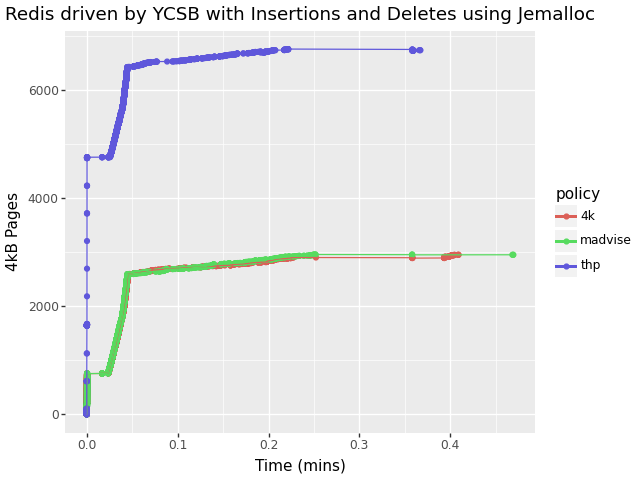

In [11]:
Image(filename="./deletes-redis.png")

In [12]:
from IPython.display import Image, display
plt = create_dtlb_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis-dtlb.png")


Processing policy: 4k
DTLB data for pid 8703: 14138 rows
Filtering DTLB data from 3955033454 to 3979566941 μs
DTLB data time range: 3955034384 to 3979570238 μs
DTLB data shape before filtering: (14138, 4)
DTLB data shape after filtering: (14138, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---                    │
│ i64 ┆ i64  ┆ i64          ┆ i64                    │
╞═════╪══════╪══════════════╪════════════════════════╡
│ 47  ┆ 8703 ┆ 3955033454   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034384   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034949   ┆ 7097                   │
└─────┴──────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---     

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-redis-dtlb.png


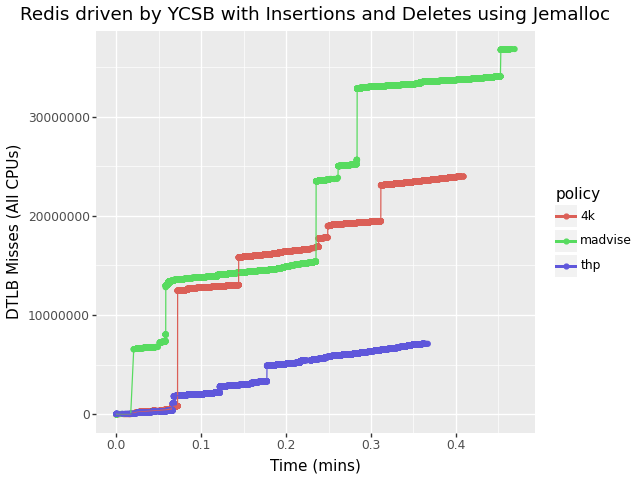

In [13]:
Image(filename="./deletes-redis-dtlb.png")

In [14]:
!pip install scikit-learn tensorflow torch

In [20]:
collect = Collector("./config/gap_never.yaml")
collect.start_collection(None)
gap_never_info = collect.wait()
collect = Collector("./config/gap_always.yaml")
collect.start_collection(None)
gap_always_info = collect.wait()
collect = Collector("./config/gap_madvise.yaml")
collect.start_collection(None)
gap_madvise_info = collect.wait()

In [21]:
from IPython.display import Image, display
plt = create_rss_graph([("4k", gap_never_info),
                    ("thp", gap_always_info)],
                   "pr", 0, 
                   "pr", 0,
                   "Gap driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-gap.png")

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-gap.png


KeyboardInterrupt: 

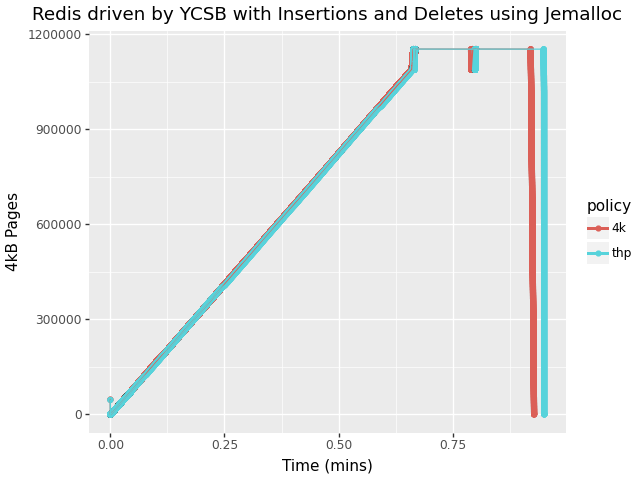

In [97]:
Image(filename="./deletes-gap.png")

In [25]:
import polars as pl
from pathlib import Path

# Suppose these functions already exist (or you adapt similar ones)
def load_memory_data(filedict: dict[str, list[Path]], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, tag: str) -> pl.DataFrame:
    df = get_proper_rss(filedict["process_trace"], filedict["mm_rss_stat"], proc_tag, proc_ind, time_proc_tag, time_proc_index, tag)
    return df.with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time")).select(["norm_time", "count"]).rename({"count": "memory"})

def load_dtlb_data(filedict: dict[str, list[Path]], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, tag: str) -> pl.DataFrame:
    df = get_proper_dtlb(filedict["process_trace"], filedict["dtlb_misses"], proc_tag, proc_ind, time_proc_tag, time_proc_index, tag)
    return df.with_columns(
        (pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time")
    ).select([
        "norm_time",
        pl.col("cumulative_dtlb_misses").alias("dtlb")
    ])

In [40]:
print("Preparing Redis data...")
redis_data = {
    'never_memory': load_memory_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'never_dtlb': load_dtlb_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'always_memory': load_memory_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always"),
    'always_dtlb': load_dtlb_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always")
}

gap_data = {
    'never_memory': load_memory_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'never_dtlb': load_dtlb_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'always_memory': load_memory_data(gap_always_info, "pr", 0, "pr", 0, "always"),
    'always_dtlb': load_dtlb_data(gap_always_info, "pr", 0, "pr", 0, "always")
}

def normalize_time(df):
    min_time = df["norm_time"].min()
    return df.with_columns((pl.col("norm_time") - min_time).alias("norm_time"))

redis_datasets = [
    ('redis_never', normalize_time(redis_data['never_memory'])),
    ('redis_never', normalize_time(redis_data['never_dtlb'])),
    ('redis_always', normalize_time(redis_data['always_memory'])),
    ('redis_always', normalize_time(redis_data['always_dtlb']))
]

gap_datasets = [
    ('gap_never', normalize_time(gap_data['never_memory'])),
    ('gap_never', normalize_time(gap_data['never_dtlb'])),
    ('gap_always', normalize_time(gap_data['always_memory'])),
    ('gap_always', normalize_time(gap_data['always_dtlb']))
]

from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

def align_datasets_on_time_grid(datasets, desired_points=1000):
    min_time = float('inf')
    max_time = float('-inf')
    for name, df in datasets:
        min_time = min(min_time, df["norm_time"].min())
        max_time = max(max_time, df["norm_time"].max())
    step_size = (max_time - min_time) / desired_points
    time_points = np.arange(min_time, max_time + step_size, step_size)
    result_df = pd.DataFrame({"norm_time": time_points})
    for name, df in datasets:
        df_pd = df.to_pandas()
        for col in df_pd.columns:
            if col != "norm_time":
                if len(df_pd) > 1:
                    interp_func = interp1d(df_pd["norm_time"].values, df_pd[col].values, bounds_error=False, fill_value="extrapolate")
                    column_name = f"{name}_{col}"
                    result_df[column_name] = interp_func(time_points)
    result_df = result_df.fillna(method='ffill').fillna(method='bfill')
    # Compute bloat condition
    if 'redis_always_memory' in result_df.columns and 'redis_never_memory' in result_df.columns:
        result_df['bloat'] = ((result_df['redis_always_memory'] < 0.85 * result_df['redis_never_memory']) | 
                            (result_df['redis_always_memory'] > 1.15 * result_df['redis_never_memory'])).astype(int)
    elif 'gap_always_memory' in result_df.columns and 'gap_never_memory' in result_df.columns:
        result_df['bloat'] = ((result_df['gap_always_memory'] < 0.85 * result_df['gap_never_memory']) | 
                            (result_df['gap_always_memory'] > 1.15 * result_df['gap_never_memory'])).astype(int)
    return result_df

redis_aligned = align_datasets_on_time_grid(redis_datasets)
gap_aligned = align_datasets_on_time_grid(gap_datasets)

def scale_data(df, columns_to_scale):
    scaling_params = {}
    for col in columns_to_scale:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            range_val = max_val - min_val
            if range_val > 0:
                df[f"{col}_scaled"] = (df[col] - min_val) / range_val
            else:
                df[f"{col}_scaled"] = 0.5
            scaling_params[col] = {'min': min_val, 'max': max_val}
    return df, scaling_params
    
# Columns to scale for Redis
redis_columns_to_scale = [
    'redis_always_memory', 'redis_always_dtlb',
    'redis_never_memory', 'redis_never_dtlb'
]

# Scale Redis data
redis_scaled, redis_scaling_params = scale_data(
    redis_aligned, 
    [col for col in redis_columns_to_scale if col in redis_aligned.columns]
)

# Columns to scale for Gap
gap_columns_to_scale = [
    'gap_always_memory', 'gap_always_dtlb',
    'gap_never_memory', 'gap_never_dtlb'
]

# Scale Gap data
gap_scaled, gap_scaling_params = scale_data(
    gap_aligned, 
    [col for col in gap_columns_to_scale if col in gap_aligned.columns]
)

Preparing Redis data...
DTLB data for pid 8703: 14138 rows
Filtering DTLB data from 3955033454 to 3979566941 μs
DTLB data time range: 3955034384 to 3979570238 μs
DTLB data shape before filtering: (14138, 4)
DTLB data shape after filtering: (14138, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---                    │
│ i64 ┆ i64  ┆ i64          ┆ i64                    │
╞═════╪══════╪══════════════╪════════════════════════╡
│ 47  ┆ 8703 ┆ 3955033454   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034384   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034949   ┆ 7097                   │
└─────┴──────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---    

/tmp/ipykernel_6356/3089297976.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/tmp/ipykernel_6356/3089297976.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [41]:
print("Preparing Redis data...")
redis_data = {
    'never_memory': load_memory_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'never_dtlb': load_dtlb_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'always_memory': load_memory_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always"),
    'always_dtlb': load_dtlb_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always")
}

gap_data = {
    'never_memory': load_memory_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'never_dtlb': load_dtlb_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'always_memory': load_memory_data(gap_always_info, "pr", 0, "pr", 0, "always"),
    'always_dtlb': load_dtlb_data(gap_always_info, "pr", 0, "pr", 0, "always")
}

def normalize_time(df):
    min_time = df["norm_time"].min()
    return df.with_columns((pl.col("norm_time") - min_time).alias("norm_time"))

redis_datasets = [
    ('redis_never', normalize_time(redis_data['never_memory'])),
    ('redis_never', normalize_time(redis_data['never_dtlb'])),
    ('redis_always', normalize_time(redis_data['always_memory'])),
    ('redis_always', normalize_time(redis_data['always_dtlb']))
]

gap_datasets = [
    ('gap_never', normalize_time(gap_data['never_memory'])),
    ('gap_never', normalize_time(gap_data['never_dtlb'])),
    ('gap_always', normalize_time(gap_data['always_memory'])),
    ('gap_always', normalize_time(gap_data['always_dtlb']))
]

from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

def align_datasets_on_time_grid(datasets, desired_points=1000):
    min_time = float('inf')
    max_time = float('-inf')
    for name, df in datasets:
        min_time = min(min_time, df["norm_time"].min())
        max_time = max(max_time, df["norm_time"].max())
    step_size = (max_time - min_time) / desired_points
    time_points = np.arange(min_time, max_time + step_size, step_size)
    result_df = pd.DataFrame({"norm_time": time_points})
    for name, df in datasets:
        df_pd = df.to_pandas()
        for col in df_pd.columns:
            if col != "norm_time":
                if len(df_pd) > 1:
                    interp_func = interp1d(df_pd["norm_time"].values, df_pd[col].values, bounds_error=False, fill_value="extrapolate")
                    column_name = f"{name}_{col}"
                    result_df[column_name] = interp_func(time_points)
    result_df = result_df.fillna(method='ffill').fillna(method='bfill')
    # Compute bloat condition
    if 'redis_always_memory' in result_df.columns and 'redis_never_memory' in result_df.columns:
        result_df['bloat'] = ((result_df['redis_always_memory'] < 0.85 * result_df['redis_never_memory']) | 
                            (result_df['redis_always_memory'] > 1.15 * result_df['redis_never_memory'])).astype(int)
    elif 'gap_always_memory' in result_df.columns and 'gap_never_memory' in result_df.columns:
        result_df['bloat'] = ((result_df['gap_always_memory'] < 0.85 * result_df['gap_never_memory']) | 
                            (result_df['gap_always_memory'] > 1.15 * result_df['gap_never_memory'])).astype(int)
    return result_df

redis_aligned = align_datasets_on_time_grid(redis_datasets)
gap_aligned = align_datasets_on_time_grid(gap_datasets)

def scale_data(df, columns_to_scale):
    scaling_params = {}
    for col in columns_to_scale:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            range_val = max_val - min_val
            if range_val > 0:
                df[f"{col}_scaled"] = (df[col] - min_val) / range_val
            else:
                df[f"{col}_scaled"] = 0.5
            scaling_params[col] = {'min': min_val, 'max': max_val}
    return df, scaling_params
    
# Columns to scale for Redis
redis_columns_to_scale = [
    'redis_always_memory', 'redis_always_dtlb',
    'redis_never_memory', 'redis_never_dtlb'
]

# Scale Redis data
redis_scaled, redis_scaling_params = scale_data(
    redis_aligned, 
    [col for col in redis_columns_to_scale if col in redis_aligned.columns]
)

# Columns to scale for Gap
gap_columns_to_scale = [
    'gap_always_memory', 'gap_always_dtlb',
    'gap_never_memory', 'gap_never_dtlb'
]

# Scale Gap data
gap_scaled, gap_scaling_params = scale_data(
    gap_aligned, 
    [col for col in gap_columns_to_scale if col in gap_aligned.columns]
)

Preparing Redis data...
DTLB data for pid 8703: 14138 rows
Filtering DTLB data from 3955033454 to 3979566941 μs
DTLB data time range: 3955034384 to 3979570238 μs
DTLB data shape before filtering: (14138, 4)
DTLB data shape after filtering: (14138, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---                    │
│ i64 ┆ i64  ┆ i64          ┆ i64                    │
╞═════╪══════╪══════════════╪════════════════════════╡
│ 47  ┆ 8703 ┆ 3955033454   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034384   ┆ 6825                   │
│ 47  ┆ 8703 ┆ 3955034949   ┆ 7097                   │
└─────┴──────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---    

/tmp/ipykernel_6356/3089297976.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/tmp/ipykernel_6356/3089297976.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [42]:
def create_time_series_samples(df, feature_cols, window_size=10, future_steps=5):
    features = df[feature_cols].values
    bloat = df['bloat'].values
    X, y, time_points = [], [], []
    for i in range(window_size, len(df) - future_steps):
        X.append(features[i-window_size:i])
        y.append([bloat[i], bloat[i + future_steps]])
        time_points.append(df['norm_time'].iloc[i])
    return np.array(X), np.array(y), np.array(time_points)

In [43]:
# Define feature and label columns for Redis
redis_columns_info = {
    'feature_cols': ['redis_always_memory_scaled', 'redis_always_dtlb_scaled'],
    'label_cols': ['redis_never_memory_scaled', 'redis_never_dtlb_scaled']
}

# Create Redis samples
window_size = 10  # Use the same window size as original


# Define feature and label columns for Gap
gap_columns_info = {
    'feature_cols': ['gap_always_memory_scaled', 'gap_always_dtlb_scaled'],
    'label_cols': ['gap_never_memory_scaled', 'gap_never_dtlb_scaled']
}
future_steps = 5

# Create Gap samples
redis_X, redis_y, redis_time = create_time_series_samples(redis_scaled, redis_columns_info['feature_cols'], window_size, future_steps)
gap_X, gap_y, gap_time = create_time_series_samples(gap_scaled, gap_columns_info['feature_cols'], window_size, future_steps)


n_samples = min(len(redis_X), len(gap_X))
np.random.seed(42)  # For reproducibility
redis_indices = np.random.choice(len(redis_X), n_samples, replace=False)
gap_indices = np.random.choice(len(gap_X), n_samples, replace=False)

redis_X_subset = redis_X[redis_indices]
redis_y_subset = redis_y[redis_indices]
redis_time_subset = redis_time[redis_indices]

gap_X_subset = gap_X[gap_indices]
gap_y_subset = gap_y[gap_indices]
gap_time_subset = gap_time[gap_indices]

# Now combine the datasets
combined_X = np.concatenate([redis_X_subset, gap_X_subset], axis=0)
combined_y = np.concatenate([redis_y_subset, gap_y_subset], axis=0)

# Keep track of dataset origin for evaluation
dataset_origins = np.concatenate([
    np.zeros(len(redis_X_subset)),  # 0 for Redis
    np.ones(len(gap_X_subset))      # 1 for Gap
])

print(f"Combined dataset shape: X={combined_X.shape}, y={combined_y.shape}")

Combined dataset shape: X=(1972, 10, 2), y=(1972, 2)


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the LSTM model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=2, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output
    
    def forward(self, x):
        # Flatten the input from (batch_size, window_size, num_features) to (batch_size, window_size * num_features)
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [52]:
def train_pytorch_model(X, y, batch_size=32, epochs=50, learning_rate=0.001, validation_split=0.2):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)  # y is [bloat_current, bloat_future], 0 or 1
    X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=validation_split, shuffle=False)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    window_size = X.shape[1]
    num_features = X.shape[2]
    input_size = window_size * num_features
    hidden_size = 16
    model = MLPModel(input_size, hidden_size)
    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        val_accuracy_current = 0
        val_accuracy_future = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                preds = torch.sigmoid(outputs) > 0.8
                val_accuracy_current += (preds[:, 0] == batch_y[:, 0]).float().mean().item() * batch_X.size(0)
                val_accuracy_future += (preds[:, 1] == batch_y[:, 1]).float().mean().item() * batch_X.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy_current = val_accuracy_current / len(val_loader.dataset)
        val_accuracy_future = val_accuracy_future / len(val_loader.dataset)
        val_losses.append(val_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Val Acc Current: {val_accuracy_current:.4f}, Val Acc Future: {val_accuracy_future:.4f}')
    torch.save(model, 'mlp_model.pth')
    return model, X_val, y_val

model, X_val_tensor, y_val_tensor = train_pytorch_model(combined_X, combined_y)


Epoch [10/50], Train Loss: 0.3059, Val Loss: 0.6832, Val Acc Current: 0.6380, Val Acc Future: 0.5013
Epoch [20/50], Train Loss: 0.2705, Val Loss: 0.5861, Val Acc Current: 0.7620, Val Acc Future: 0.7570
Epoch [30/50], Train Loss: 0.2563, Val Loss: 0.5267, Val Acc Current: 0.7620, Val Acc Future: 0.7570
Epoch [40/50], Train Loss: 0.2470, Val Loss: 0.5248, Val Acc Current: 0.7620, Val Acc Future: 0.7570
Epoch [50/50], Train Loss: 0.2386, Val Loss: 0.4812, Val Acc Current: 0.8127, Val Acc Future: 0.8076


In [53]:
# Load and preprocess madvise data for Redis
redis_madvise_memory = get_proper_rss(
    redis_madvise_info["process_trace"][0],
    redis_madvise_info["mm_rss_stat"][0],
    "redis-server", 0,
    "redis-server", 0,
    "madvise"
).with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))

redis_madvise_dtlb = get_proper_dtlb(
    redis_madvise_info["process_trace"][0],
    redis_madvise_info["dtlb_misses"][0],
    "redis-server", 0,
    "redis-server", 0,
    "madvise"
).with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))

# Load and preprocess madvise data for Gap
gap_madvise_memory = get_proper_rss(
    gap_madvise_info["process_trace"][0],
    gap_madvise_info["mm_rss_stat"][0],
    "pr", 0,
    "pr", 0,
    "madvise"
).with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))

gap_madvise_dtlb = get_proper_dtlb(
    gap_madvise_info["process_trace"][0],
    gap_madvise_info["dtlb_misses"][0],
    "pr", 0,
    "pr", 0,
    "madvise"
).with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))

DTLB data for pid 9454: 13116 rows
Filtering DTLB data from 3993534205 to 4021685443 μs
DTLB data time range: 3993534658 to 4021685861 μs
DTLB data shape before filtering: (13116, 4)
DTLB data shape after filtering: (13116, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---                    │
│ i64 ┆ i64  ┆ i64          ┆ i64                    │
╞═════╪══════╪══════════════╪════════════════════════╡
│ 45  ┆ 9454 ┆ 3993534205   ┆ 8253                   │
│ 45  ┆ 9454 ┆ 3993534658   ┆ 8253                   │
│ 45  ┆ 9454 ┆ 3993535820   ┆ 8777                   │
└─────┴──────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬──────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---  ┆ ---          ┆ ---                    │
│ i64 

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import interp1d


def evaluate_model_on_dataset(model, X, y, dataset_name, time_val=None):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred_logits = model(X_tensor)
        y_pred_prob = torch.sigmoid(y_pred_logits).numpy()
        y_pred_class = (y_pred_prob > 0.8).astype(int)
    bloat_current_actual = y[:, 0]
    bloat_future_actual = y[:, 1]
    bloat_current_pred_prob = y_pred_prob[:, 0]
    bloat_future_pred_prob = y_pred_prob[:, 1]
    bloat_current_pred = y_pred_class[:, 0]
    bloat_future_pred = y_pred_class[:, 1]
    accuracy_current = np.mean(bloat_current_pred == bloat_current_actual)
    accuracy_future = np.mean(bloat_future_pred == bloat_future_actual)
    time_points = time_val if time_val is not None else np.linspace(0, len(y) / 10, len(y))
    sorted_indices = np.argsort(time_points)
    time_points = time_points[sorted_indices]
    bloat_current_actual = bloat_current_actual[sorted_indices]
    bloat_current_pred_prob = bloat_current_pred_prob[sorted_indices]
    bloat_future_actual = bloat_future_actual[sorted_indices]
    bloat_future_pred_prob = bloat_future_pred_prob[sorted_indices]
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, bloat_current_pred_prob, 'r-', label='Predicted Probability')
    plt.scatter(time_points, bloat_current_actual, c='b', marker='o', alpha=0.5, label='Actual Bloat')
    plt.title(f'{dataset_name} Current Bloat Prediction: Accuracy={accuracy_current:.4f}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Bloat Probability / Actual')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name.lower()}_bloat_current_prediction.png")
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, bloat_future_pred_prob, 'r-', label='Predicted Probability (t+5)')
    plt.scatter(time_points, bloat_future_actual, c='b', marker='o', alpha=0.5, label='Actual Bloat (t+5)')
    plt.title(f'{dataset_name} Future Bloat Prediction: Accuracy={accuracy_future:.4f}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Bloat Probability / Actual')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name.lower()}_bloat_future_prediction.png")
    plt.close()
    return {'accuracy_current': accuracy_current, 'accuracy_future': accuracy_future}

Evaluating on Redis benchmark:
Evaluating on Gap benchmark:

Cross-benchmark Performance Comparison:
Metric                         Redis             Gap
Accuracy Current              0.8832          0.8680
Accuracy Future               0.8883          0.8680

Redis Current Bloat Prediction:


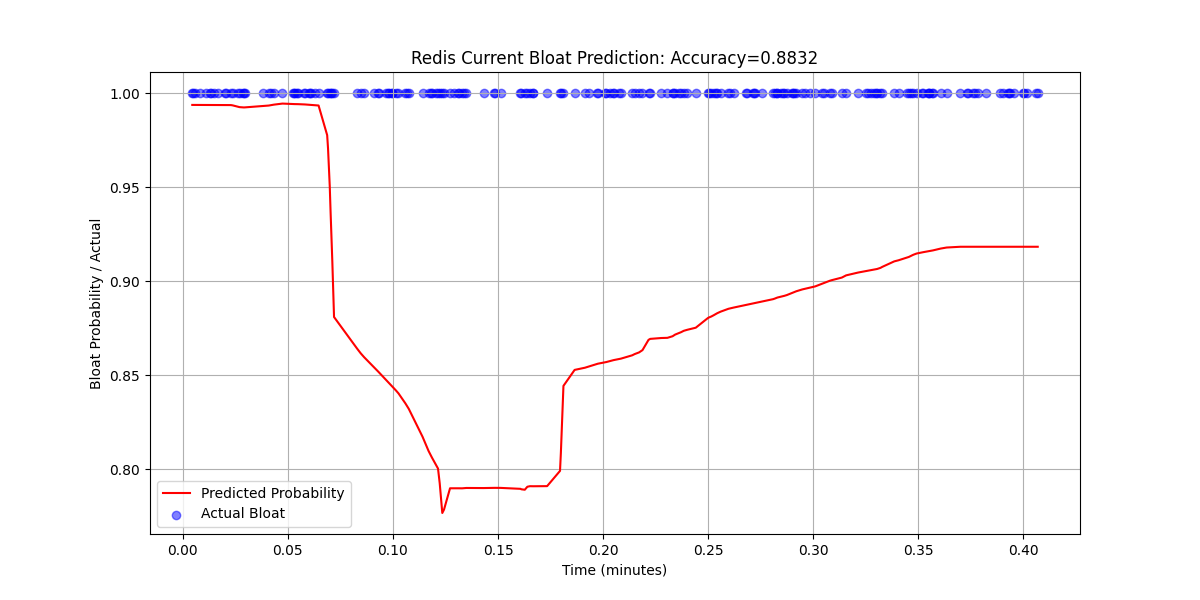


Redis Future Bloat Prediction:


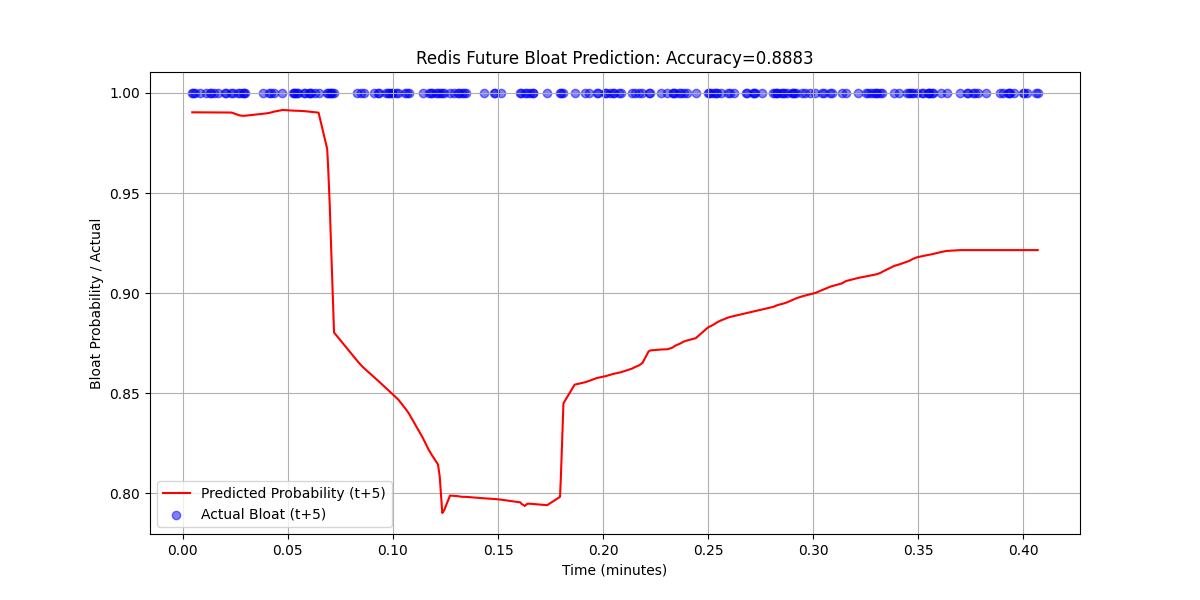


Gap Current Bloat Prediction:


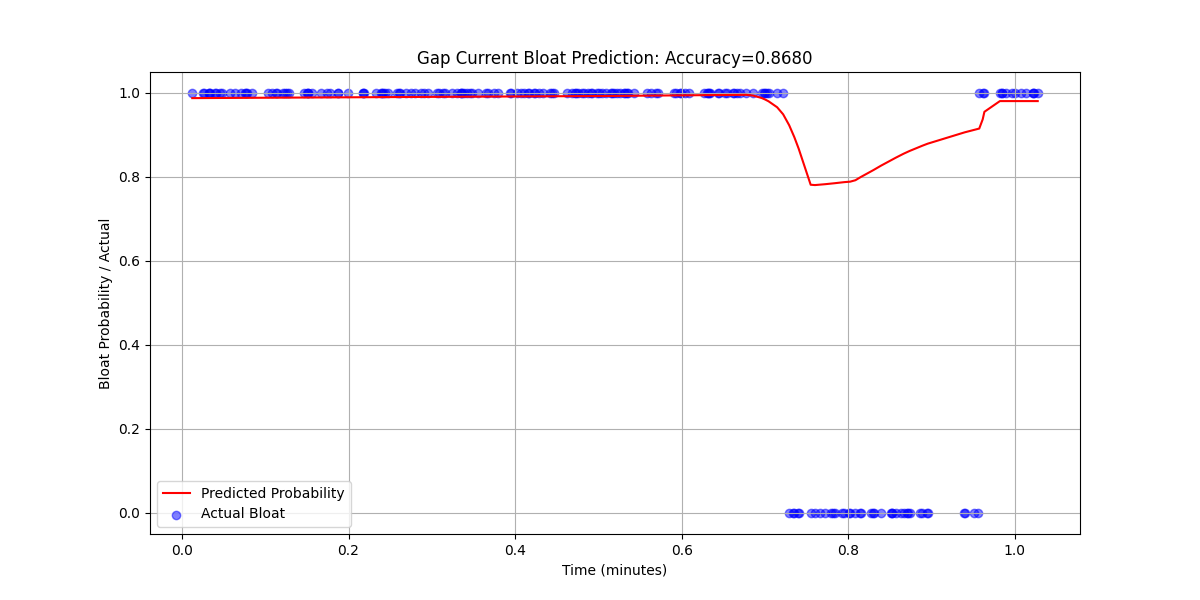


Gap Future Bloat Prediction:


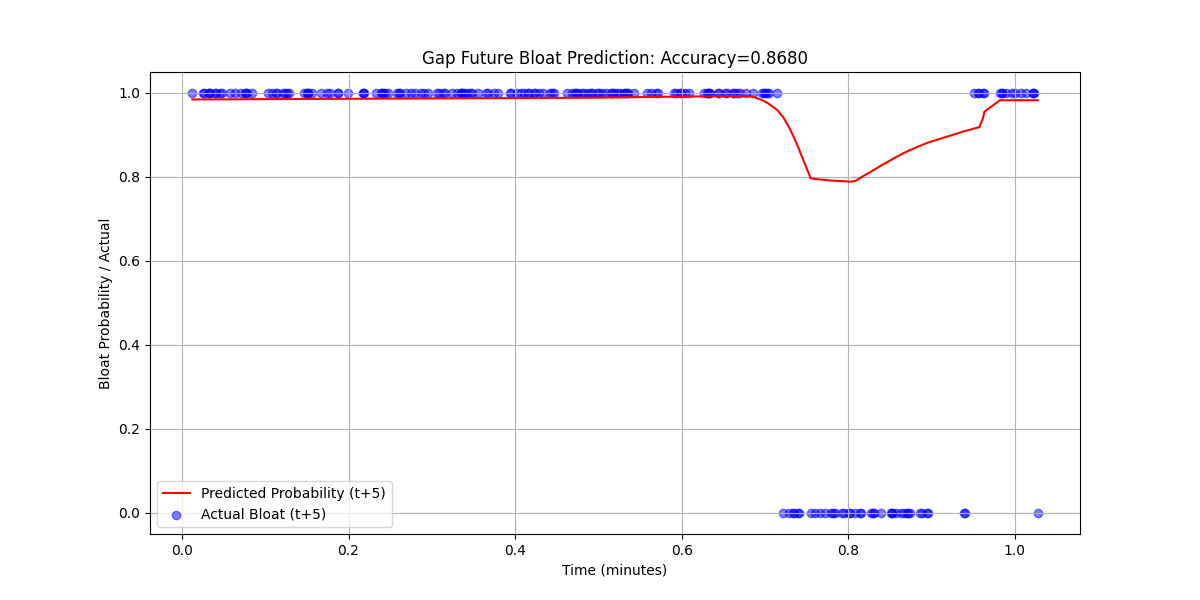

In [55]:
redis_test_indices = np.random.choice(len(redis_X), int(len(redis_X) * 0.2), replace=False)
redis_test_X = redis_X[redis_test_indices]
redis_test_y = redis_y[redis_test_indices]
gap_test_indices = np.random.choice(len(gap_X), int(len(gap_X) * 0.2), replace=False)
gap_test_X = gap_X[gap_test_indices]
gap_test_y = gap_y[gap_test_indices]

print("Evaluating on Redis benchmark:")
redis_metrics = evaluate_model_on_dataset(model, redis_test_X, redis_test_y, "Redis", redis_time[redis_test_indices])

print("Evaluating on Gap benchmark:")
gap_metrics = evaluate_model_on_dataset(model, gap_test_X, gap_test_y, "Gap", gap_time[gap_test_indices])

print("\nCross-benchmark Performance Comparison:")
print(f"{'Metric':<20} {'Redis':>15} {'Gap':>15}")
print(f"{'Accuracy Current':<20} {redis_metrics['accuracy_current']:>15.4f} {gap_metrics['accuracy_current']:>15.4f}")
print(f"{'Accuracy Future':<20} {redis_metrics['accuracy_future']:>15.4f} {gap_metrics['accuracy_future']:>15.4f}")

print("\nRedis Current Bloat Prediction:")
display(Image(filename="redis_bloat_current_prediction.png"))
print("\nRedis Future Bloat Prediction:")
display(Image(filename="redis_bloat_future_prediction.png"))
print("\nGap Current Bloat Prediction:")
display(Image(filename="gap_bloat_current_prediction.png"))
print("\nGap Future Bloat Prediction:")
display(Image(filename="gap_bloat_future_prediction.png"))


Loaded model from ./bloat_classifier.pth

Running evaluation for Redis re-test
Running collection for configuration: redis_never
Running collection for configuration: redis_always
Running collection for configuration: redis_madvise
DTLB data for pid 16418: 13806 rows
Filtering DTLB data from 5486738748 to 5512679798 μs
DTLB data time range: 5486738985 to 5512681249 μs
DTLB data shape before filtering: (13806, 4)
DTLB data shape after filtering: (13804, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬───────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid  ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---   ┆ ---          ┆ ---                    │
│ i64 ┆ i64   ┆ i64          ┆ i64                    │
╞═════╪═══════╪══════════════╪════════════════════════╡
│ 38  ┆ 16418 ┆ 5486738748   ┆ 43540                  │
│ 38  ┆ 16418 ┆ 5486738985   ┆ 43540                  │
│ 38  ┆ 16418 ┆ 5486740563   ┆ 45004                  │
└─────┴───────┴──────────────┴────────

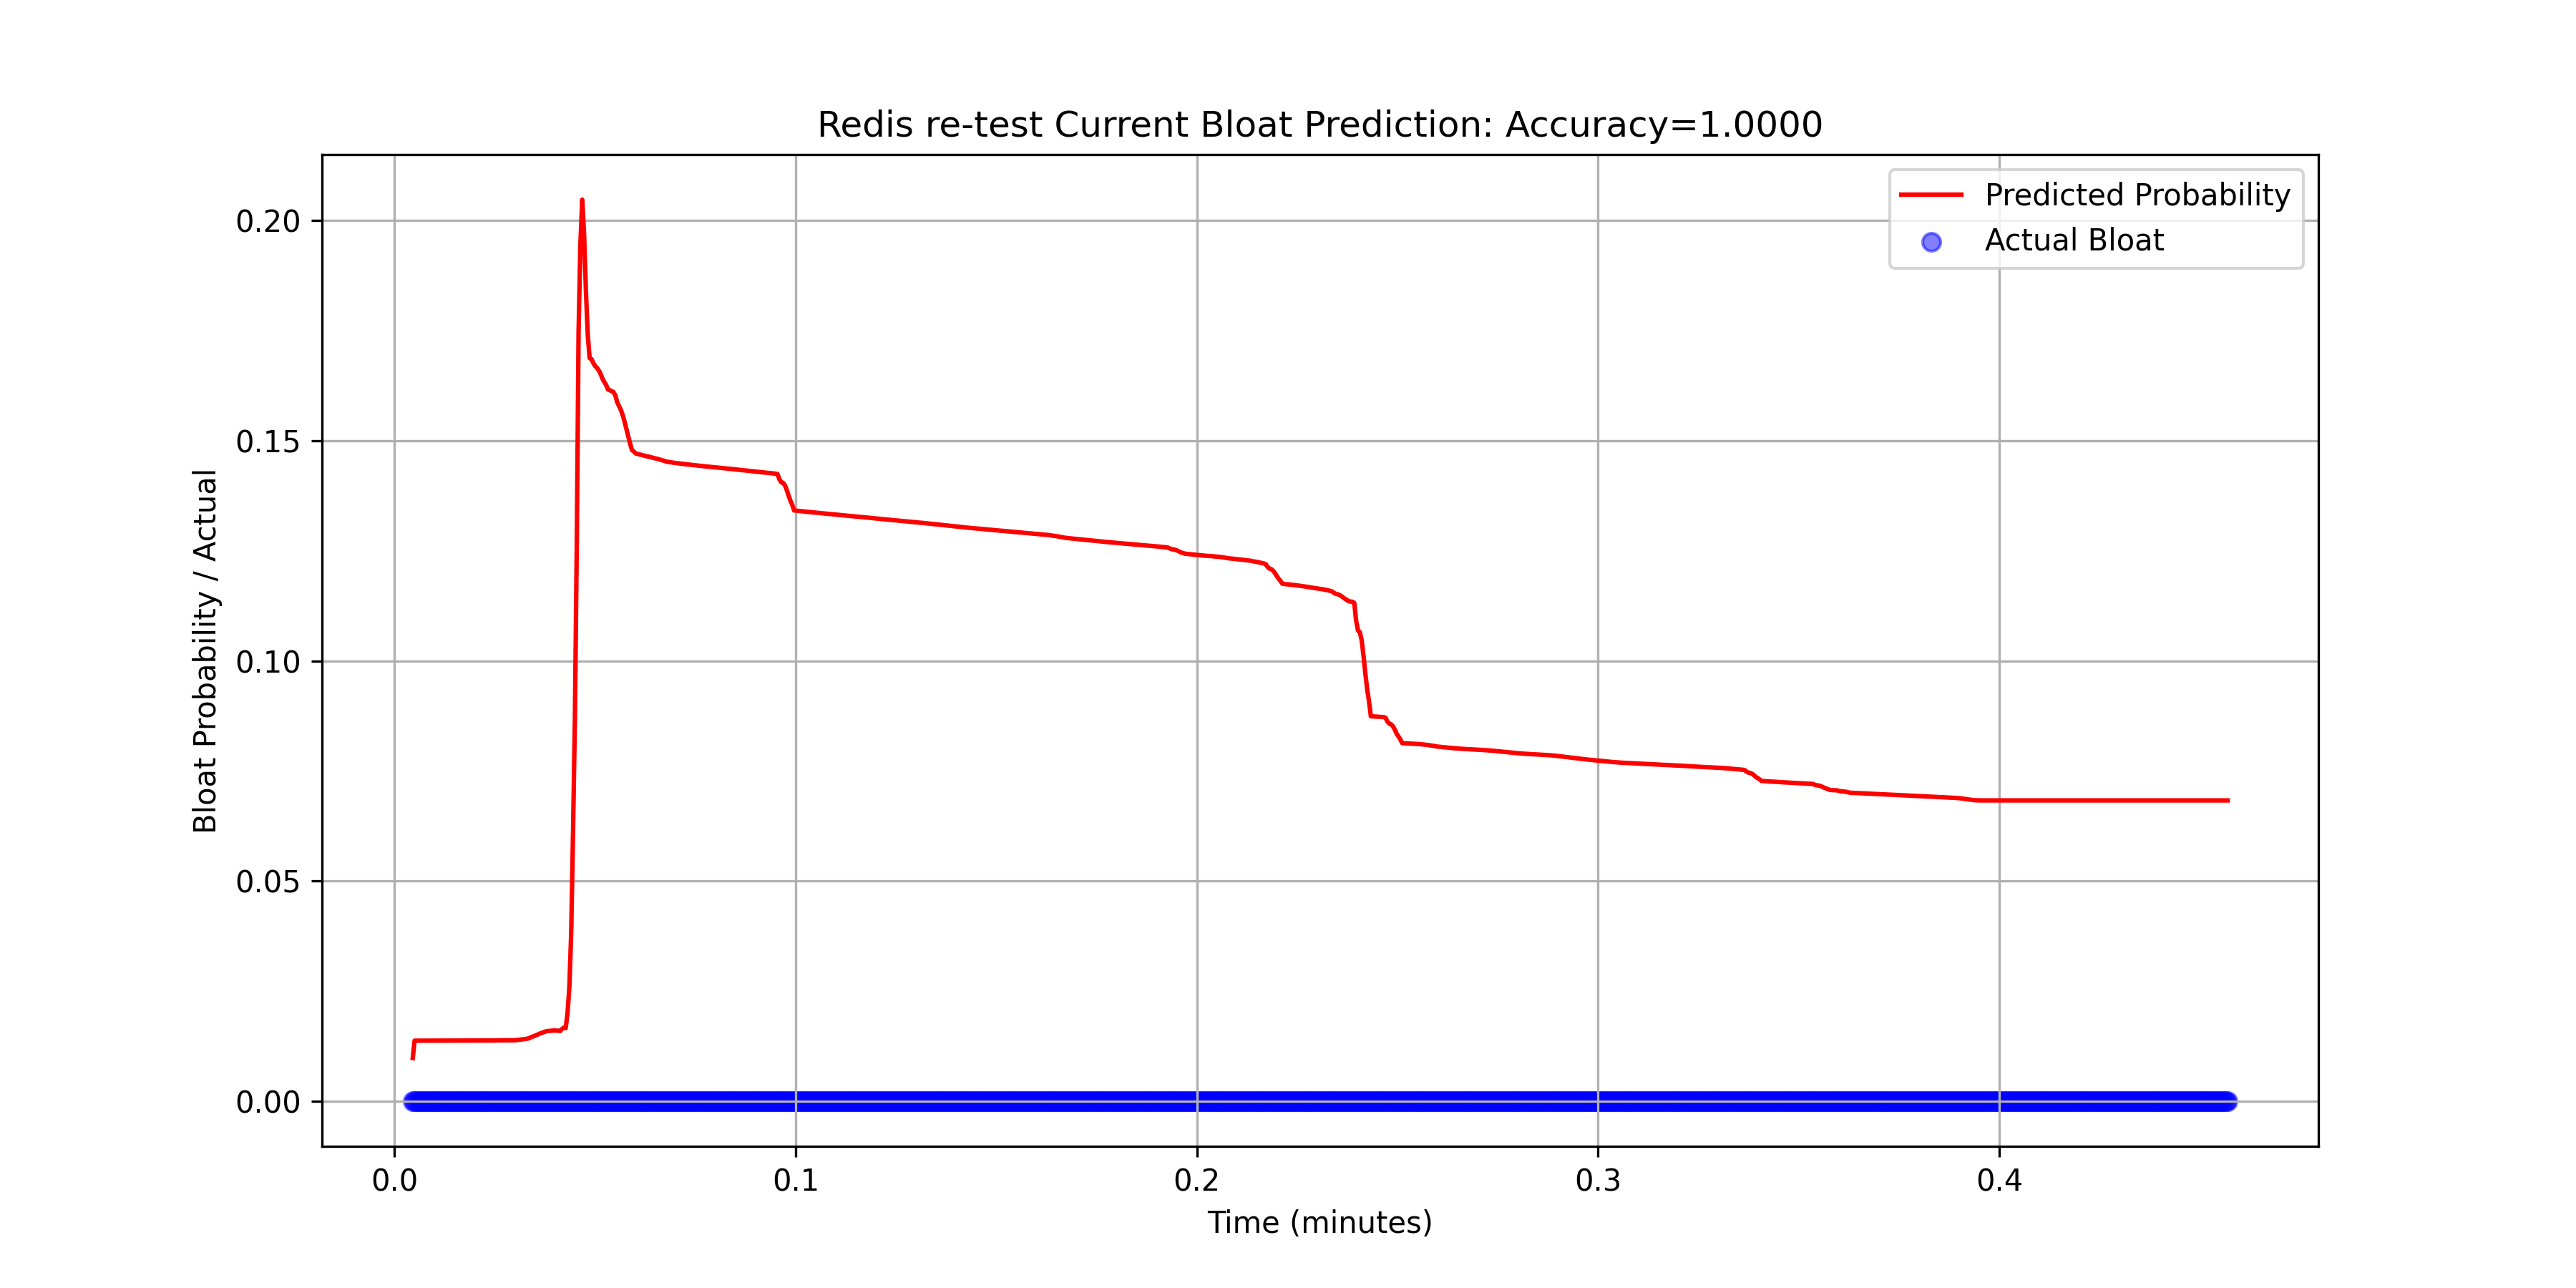


Redis re-test Future Bloat Prediction:


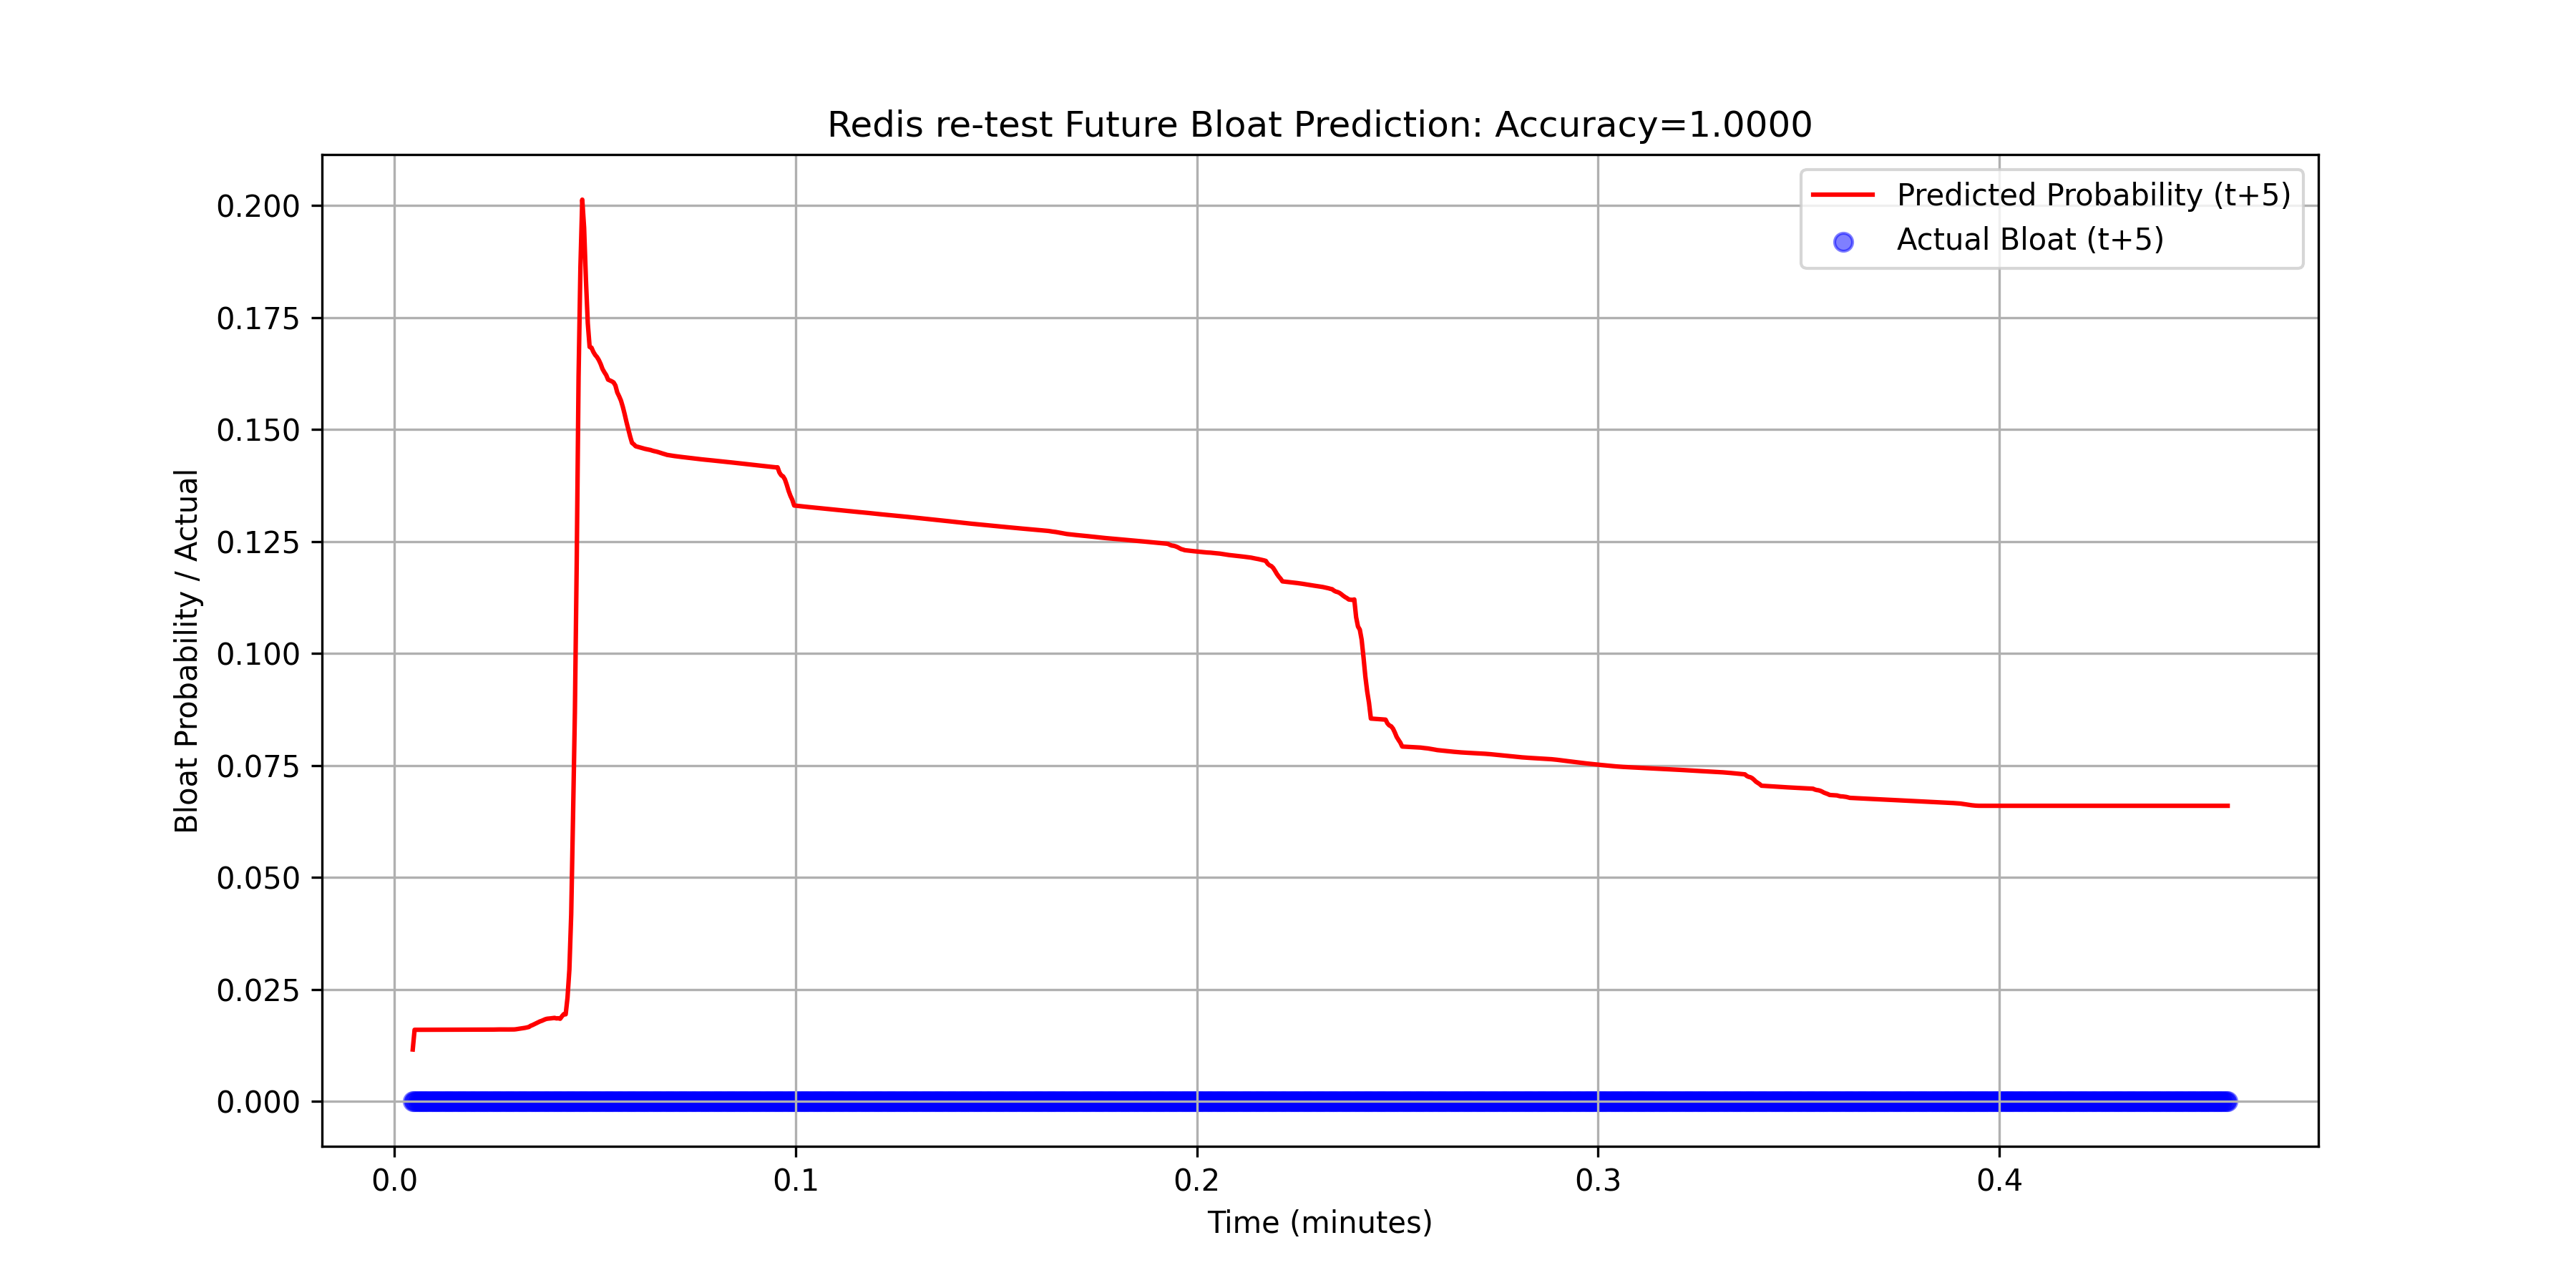


Redis re-test Memory Comparison:


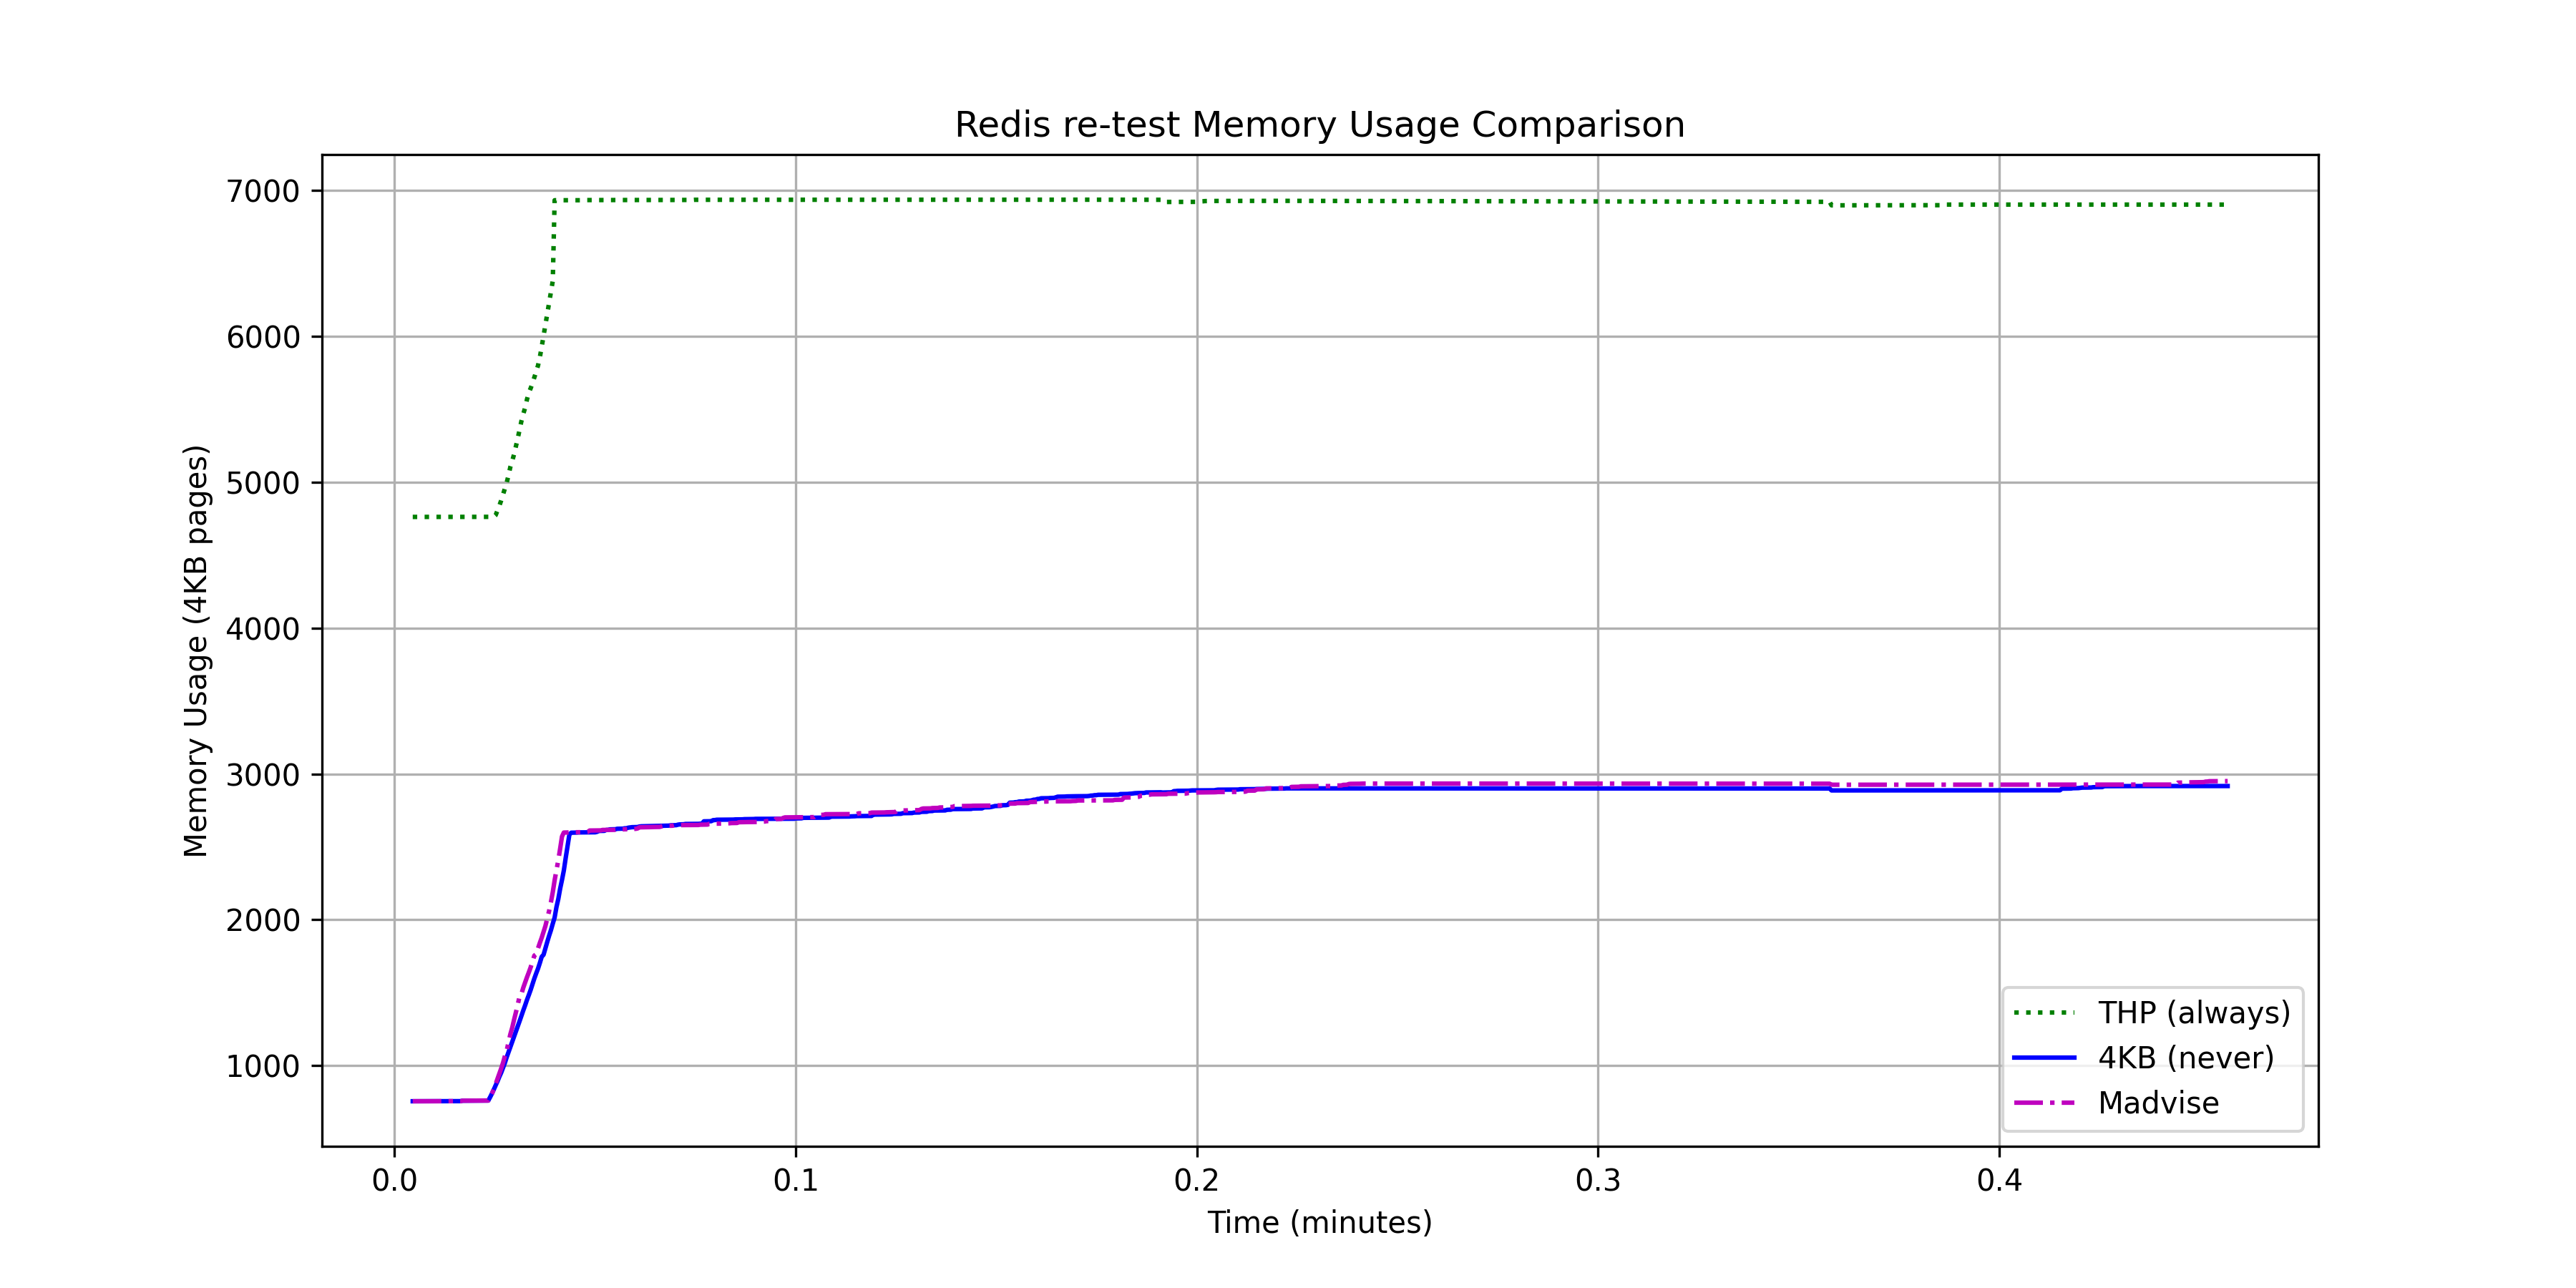


Running evaluation for Gap re-test
Running collection for configuration: gap_never
Running collection for configuration: gap_always


KeyboardInterrupt: 

In [39]:
import torch
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import Image, display

# Assume these functions are defined from your original script
# - Collector class
# - get_proper_rss
# - get_proper_dtlb
# - filter_process_trace

def load_trained_model(model_path):
    """Load a trained PyTorch MLP model saved as a full model."""
    model = torch.load(model_path, weights_only=False)
    model.eval()
    return model

def collect_test_data(config_paths):
    """Collect data for multiple test configurations."""
    results = {}
    for config_path in config_paths:
        config_name = Path(config_path).stem
        print(f"Running collection for configuration: {config_name}")
        collector = Collector(config_path)
        collector.start_collection(None)
        file_info = collector.wait()
        results[config_name] = file_info
    return results

def preprocess_data(file_info, proc_tag, proc_ind, time_proc_tag, time_proc_index, policy_tag):
    """Preprocess data for a single configuration."""
    memory_df = get_proper_rss(
        file_info["process_trace"],
        file_info["mm_rss_stat"],
        proc_tag, proc_ind,
        time_proc_tag, time_proc_index,
        policy_tag
    ).with_columns(
        (pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time")
    )
    dtlb_df = get_proper_dtlb(
        file_info["process_trace"],
        file_info["dtlb_misses"],
        proc_tag, proc_ind,
        time_proc_tag, time_proc_index,
        policy_tag
    ).with_columns(
        (pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time")
    )
    return {
        "memory": memory_df.select(["norm_time", "count"]).rename({"count": "memory"}),
        "dtlb": dtlb_df.select(["norm_time", "cumulative_dtlb_misses"]).rename({"cumulative_dtlb_misses": "dtlb"})
    }

def align_and_scale_data(always_data, never_data, madvise_data=None, desired_points=1000):
    """Align and scale data to a common time grid, compute bloat condition."""
    always_memory_pd = always_data["memory"].to_pandas()
    always_dtlb_pd = always_data["dtlb"].to_pandas()
    never_memory_pd = never_data["memory"].to_pandas()
    never_dtlb_pd = never_data["dtlb"].to_pandas()
    
    min_time = min(
        always_memory_pd["norm_time"].min(),
        always_dtlb_pd["norm_time"].min(),
        never_memory_pd["norm_time"].min(),
        never_dtlb_pd["norm_time"].min()
    )
    max_time = max(
        always_memory_pd["norm_time"].max(),
        always_dtlb_pd["norm_time"].max(),
        never_memory_pd["norm_time"].max(),
        never_dtlb_pd["norm_time"].max()
    )
    
    if madvise_data:
        madvise_memory_pd = madvise_data["memory"].to_pandas()
        madvise_dtlb_pd = madvise_data["dtlb"].to_pandas()
        min_time = min(min_time, madvise_memory_pd["norm_time"].min(), madvise_dtlb_pd["norm_time"].min())
        max_time = max(max_time, madvise_memory_pd["norm_time"].max(), madvise_dtlb_pd["norm_time"].max())
    
    step_size = (max_time - min_time) / desired_points
    time_points = np.arange(min_time, max_time + step_size, step_size)
    result_df = pd.DataFrame({"norm_time": time_points})
    
    always_memory_interp = interp1d(
        always_memory_pd["norm_time"].values,
        always_memory_pd["memory"].values,
        bounds_error=False,
        fill_value="extrapolate"
    )
    always_dtlb_interp = interp1d(
        always_dtlb_pd["norm_time"].values,
        always_dtlb_pd["dtlb"].values,
        bounds_error=False,
        fill_value="extrapolate"
    )
    never_memory_interp = interp1d(
        never_memory_pd["norm_time"].values,
        never_memory_pd["memory"].values,
        bounds_error=False,
        fill_value="extrapolate"
    )
    never_dtlb_interp = interp1d(
        never_dtlb_pd["norm_time"].values,
        never_dtlb_pd["dtlb"].values,
        bounds_error=False,
        fill_value="extrapolate"
    )
    
    result_df["always_memory"] = always_memory_interp(time_points)
    result_df["always_dtlb"] = always_dtlb_interp(time_points)
    result_df["never_memory"] = never_memory_interp(time_points)
    result_df["never_dtlb"] = never_dtlb_interp(time_points)
    
    # Compute bloat condition
    result_df["bloat"] = (
        (0.85 * result_df["never_memory"] <= result_df["always_memory"]) & 
        (result_df["always_memory"] <= 1.15 * result_df["never_memory"])
    ).astype(int)
    
    if madvise_data:
        madvise_memory_interp = interp1d(
            madvise_memory_pd["norm_time"].values,
            madvise_memory_pd["memory"].values,
            bounds_error=False,
            fill_value="extrapolate"
        )
        result_df["madvise_memory"] = madvise_memory_interp(time_points)
    
    # Scale only input features for the model
    scaling_params = {}
    columns_to_scale = ["always_memory", "always_dtlb"]
    if madvise_data:
        columns_to_scale.append("madvise_memory")
    
    for col in columns_to_scale:
        min_val = result_df[col].min()
        max_val = result_df[col].max()
        range_val = max_val - min_val
        if range_val > 0:
            result_df[f"{col}_scaled"] = (result_df[col] - min_val) / range_val
        else:
            result_df[f"{col}_scaled"] = 0.5
        scaling_params[col] = {'min': min_val, 'max': max_val}
    
    return result_df, scaling_params

def create_time_series_samples(df, window_size=10, future_steps=5):
    """Create time series samples for bloat prediction."""
    features = df[["always_memory_scaled", "always_dtlb_scaled"]].values
    bloat = df["bloat"].values
    X, y, time_points = [], [], []
    for i in range(window_size, len(df) - future_steps):
        X.append(features[i-window_size:i])
        y.append([bloat[i], bloat[i + future_steps]])
        time_points.append(df["norm_time"].iloc[i])
    return np.array(X), np.array(y), np.array(time_points)

def evaluate_model_on_new_data(model, aligned_df, scaling_params, window_size=10, tag="NewTest"):
    """Evaluate the classification model on new data."""
    X, y, time_points = create_time_series_samples(aligned_df, window_size)
    
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred_logits = model(X_tensor)
        y_pred_prob = torch.sigmoid(y_pred_logits).numpy()
        y_pred_class = (y_pred_prob > 0.5).astype(int)
    
    bloat_current_actual = y[:, 0]
    bloat_future_actual = y[:, 1]
    bloat_current_pred_prob = y_pred_prob[:, 0]
    bloat_future_pred_prob = y_pred_prob[:, 1]
    bloat_current_pred = y_pred_class[:, 0]
    bloat_future_pred = y_pred_class[:, 1]
    
    accuracy_current = np.mean(bloat_current_pred == bloat_current_actual)
    accuracy_future = np.mean(bloat_future_pred == bloat_future_actual)
    
    # Unscale memory values for visualization
    memory_always = aligned_df["always_memory"].values[window_size:-future_steps]
    memory_never = aligned_df["never_memory"].values[window_size:-future_steps]
    has_madvise = "madvise_memory" in aligned_df.columns
    if has_madvise:
        memory_madvise = aligned_df["madvise_memory"].values[window_size:-future_steps]
    
    # Plot bloat current prediction
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, bloat_current_pred_prob, 'r-', label='Predicted Probability')
    plt.scatter(time_points, bloat_current_actual, c='b', marker='o', alpha=0.5, label='Actual Bloat')
    plt.title(f'{tag} Current Bloat Prediction: Accuracy={accuracy_current:.4f}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Bloat Probability / Actual')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{tag.lower()}_bloat_current_prediction.png", dpi=300)
    plt.close()
    
    # Plot bloat future prediction
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, bloat_future_pred_prob, 'r-', label='Predicted Probability (t+5)')
    plt.scatter(time_points, bloat_future_actual, c='b', marker='o', alpha=0.5, label='Actual Bloat (t+5)')
    plt.title(f'{tag} Future Bloat Prediction: Accuracy={accuracy_future:.4f}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Bloat Probability / Actual')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{tag.lower()}_bloat_future_prediction.png", dpi=300)
    plt.close()
    
    # Plot memory comparison
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, memory_always, 'g:', label='THP (always)')
    plt.plot(time_points, memory_never, 'b-', label='4KB (never)')
    if has_madvise:
        plt.plot(time_points, memory_madvise, 'm-.', label='Madvise')
    plt.title(f'{tag} Memory Usage Comparison')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Memory Usage (4KB pages)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{tag.lower()}_memory_comparison.png", dpi=300)
    plt.close()
    
    return {
        'accuracy_current': accuracy_current,
        'accuracy_future': accuracy_future
    }

def run_model_evaluation(model_path, test_configs, window_size=10):
    """Run evaluation on new test configurations with the classification model."""
    model = load_trained_model(model_path)
    print(f"Loaded model from {model_path}")
    results = {}
    
    for test_name, config_paths in test_configs.items():
        print(f"\n{'='*50}")
        print(f"Running evaluation for {test_name}")
        print(f"{'='*50}")
        
        config_names = [Path(path).stem for path in config_paths]
        never_idx = next((i for i, name in enumerate(config_names) if 'never' in name.lower()), None)
        always_idx = next((i for i, name in enumerate(config_names) if 'always' in name.lower()), None)
        madvise_idx = next((i for i, name in enumerate(config_names) if 'madvise' in name.lower()), None)
        
        if never_idx is None or always_idx is None:
            print(f"Error: Missing required 'never' or 'always' configuration for {test_name}")
            continue
        
        test_data = collect_test_data(config_paths)
        
        if 'mysql' in test_name.lower():
            proc_tag, proc_ind = "mysqld", 0
            time_proc_tag, time_proc_index = "mysqld", 0
        elif 'redis' in test_name.lower():
            proc_tag, proc_ind = "redis-server", 0
            time_proc_tag, time_proc_index = "redis-server", 0
        elif 'gap' in test_name.lower() or 'pr' in test_name.lower():
            proc_tag, proc_ind = "pr", 0
            time_proc_tag, time_proc_index = "pr", 0
        else:
            print(f"Warning: Unknown test type {test_name}, using default process detection")
            never_config = config_names[never_idx]
            proc_trace_df = pl.read_parquet(test_data[never_config]["process_trace"])
            filtered_df = filter_process_trace(proc_trace_df)
            proc_tag = filtered_df["full_name"][0]
            proc_ind = 0
            time_proc_tag, time_proc_index = proc_tag, 0
            print(f"Detected process: {proc_tag}")
        
        never_config = config_names[never_idx]
        always_config = config_names[always_idx]
        never_data = preprocess_data(test_data[never_config], proc_tag, proc_ind, time_proc_tag, time_proc_index, "never")
        always_data = preprocess_data(test_data[always_config], proc_tag, proc_ind, time_proc_tag, time_proc_index, "always")
        
        madvise_data = None
        if madvise_idx is not None:
            madvise_config = config_names[madvise_idx]
            madvise_data = preprocess_data(test_data[madvise_config], proc_tag, proc_ind, time_proc_tag, time_proc_index, "madvise")
        
        aligned_df, scaling_params = align_and_scale_data(always_data, never_data, madvise_data)
        
        evaluation_results = evaluate_model_on_new_data(model, aligned_df, scaling_params, window_size, test_name)
        results[test_name] = evaluation_results
        
        print(f"\nEvaluation results for {test_name}:")
        print(f"Accuracy Current Bloat: {evaluation_results['accuracy_current']:.4f}")
        print(f"Accuracy Future Bloat: {evaluation_results['accuracy_future']:.4f}")
        
        print(f"\n{test_name} Current Bloat Prediction:")
        display(Image(filename=f"{test_name.lower()}_bloat_current_prediction.png"))
        print(f"\n{test_name} Future Bloat Prediction:")
        display(Image(filename=f"{test_name.lower()}_bloat_future_prediction.png"))
        print(f"\n{test_name} Memory Comparison:")
        display(Image(filename=f"{test_name.lower()}_memory_comparison.png"))
    
    print("\nCross-application Performance Comparison:")
    print("-" * 60)
    print(f"{'Metric':<20} {' '.join(f'{name:>15}' for name in results.keys())}")
    print("-" * 60)
    metrics = ['accuracy_current', 'accuracy_future']
    for metric in metrics:
        values = [results[name][metric] for name in results.keys()]
        print(f"{metric:<20} {' '.join(f'{value:>15.4f}' for value in values)}")
    print("-" * 60)
    
    return results

if __name__ == "__main__":
    model_path = "./bloat_classifier.pth"
    test_configs = {
        'Redis re-test': [
            './config/redis_never.yaml',
            './config/redis_always.yaml',
            './config/redis_madvise.yaml'
        ],
        'Gap re-test': [
            './config/gap_never.yaml',
            './config/gap_always.yaml',
            './config/gap_madvise.yaml'
        ]
    }
    results = run_model_evaluation(model_path, test_configs)